# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

## Откройте и изучите файл

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from joblib import dump

In [4]:
df = pd.read_csv('/datasets/users_behavior.csv')


## Разбейте данные на выборки

Отдельной тестовой выборки у нас нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1 (то есть 60%/20%/20%)

Сперва посмотрим на датасет и отделим целевой признак - тариф.

In [3]:
print(df.info())
df.head()

In [5]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [6]:
#Разбиваем данные на выборки

features_train, features_valid, target_train, target_valid = train_test_split(features\
                     ,target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid\
                        ,target_valid, test_size=0.5, random_state=12345)

## Исследуйте модели

Опробуем три модели классификатора:
    
    - Дерево решений (DecisionTreeClassifier)
    - Случайный лес (RandomForestClassifier)
    - Логистическая регрессия (LogisticRegression)


### Дерево решений

In [7]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    #опробуем глубину дерева от 1 до 10 
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions)
    print(result)
    if result > best_tree_result:
        best_tree_model = model
        best_tree_depth = depth
        best_tree_result = result
print()        
print("Accuracy лучшей модели дерева решений на валидационной выборке:"\
      , best_tree_result, ", с глубиной", best_tree_depth)

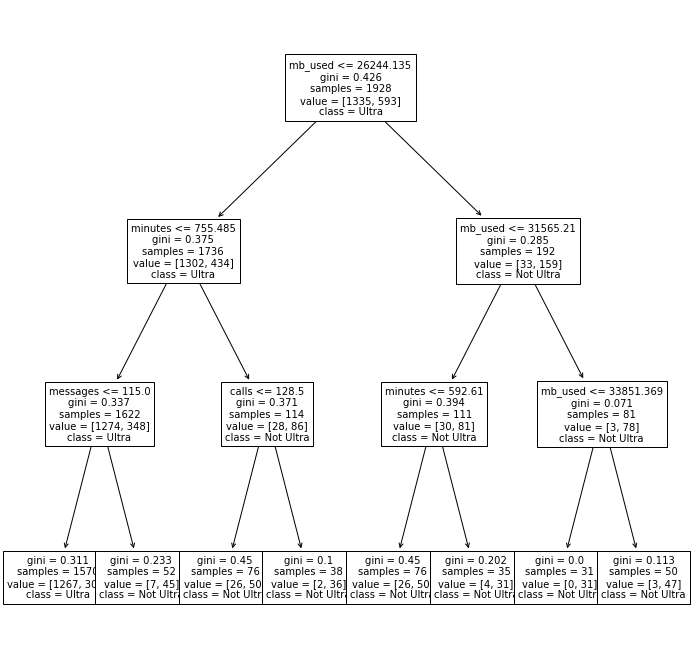

In [8]:
plt.figure(figsize=(12,12))
tree.plot_tree(best_tree_model,fontsize=10, \
               feature_names = features.columns, class_names = ['Ultra', 'Not Ultra'])
plt.show()

### Случайный лес

In [9]:
best_forest_model = None
best_forest_result = 0
best_forest_depth = 0
best_forest_est = 0

for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est,max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_forest_result:
            best_forest_model = model
            best_forest_result = result
            best_forest_est = est
            best_forest_depth = depth

print('Accuracy лучшей модели случайный лес:',best_forest_result, ",",\
      "с глубиной", best_forest_depth, "и числом деревьев", best_forest_est)

### Логистическая регрессия

In [10]:
log_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
log_model.fit(features_train, target_train)
dump(model, 'model_9_1.joblib')
log_model_result = log_model.score(features_valid, target_valid)
print('Accuracy модели логистическая регрессия:',log_model_result)

## Проверьте модель на тестовой выборке

Лучше всех показал себя случайный лес, но, возможно, модель переобучилась. Проверим все три модели на тестовой выборке.

In [11]:
#Дерево решений
best_tree_model.score(features_test, target_test)

In [12]:
#Случайный лес
best_forest_model.score(features_test, target_test)

In [13]:
#Логистическая регрессия
log_model.score(features_test, target_test)

Логистическая регрессия показала результат 68%, качество лучшей модели дерева решений оказалось 78%, а лучшей модели случайный лес - почти 80%.

## (бонус) Проверьте модели на адекватность

In [14]:
#Посмотрим на соотношение классов в тренировочной выборке.
target_train.sum()/len(target_train)

На тарифе Ultra всего 30 процентов пользователей, то есть модели нужно будет достичь accuracy не меньше 70% на тестовой выборке для того, чтобы ее существование имело смысл.

Наша лучшая модель - Random forest с глубиной 8 деревьев и 40 деревьями достигла качества (accuracy) 80% - то есть проходит этот фильтр.

## Выводы

Мы обучили три вида моделей - логистическую регрессию, дерево решений и случайный лес. По качеству модели на валидационной и на тестовой выборках победила модель случайный лес с качеством 80%. 

Следует отметить, что изначально классы в тренировочной выборке не сбалансированы с соотношением 70/30.

